In [1]:
import xarray as xr
import numpy as np
import xarray as xr
import os
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import os
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import pandas as pd
from scipy import stats

import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import pandas as pd
from scipy import stats


In [63]:
class ModelEvaluation:
    def __init__(self, prediction_files, ground_truth_file, climatology_file, climatology_std_file, save_dir, entire_era_file, var):
        self.prediction_datasets = [self.transform_data(xr.open_dataset(file)[var]) for file in prediction_files]
        self.ground_truth_dataset = self.transform_data(xr.open_dataset(ground_truth_file)[var])
        self.climatology_dataset = self.transform_data(xr.open_dataset(climatology_file)[var])
        self.climatology_std_dataset = self.transform_data(xr.open_dataset(climatology_std_file)[var])
        self.era_entire_dataset = xr.open_dataset(entire_era_file)[var]*1000
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        self.save_folder = os.path.join(self.save_dir, prediction_files[0].split('/')[-3])
        os.makedirs(self.save_folder, exist_ok=True)
        
        self.var = var
        self.extreme_threshold = self._calculate_extreme_threshold()
        self.drought_threshold = self._calculate_drought_threshold()
        self.nb_ensemble = len(self.prediction_datasets)
        self.nb_climatology_samples = 1 # Match the number of climatology samples to the ensemble size

    def transform_data(self, da):
        mask = ~np.isnan(da).any(dim=['latitude', 'longitude'])
        
        def get_valid_times(sample_mask):
            return np.where(sample_mask)[0]
        
        valid_time_indices = xr.apply_ufunc(
            get_valid_times,
            mask,
            input_core_dims=[['time']],
            output_core_dims=[['valid_time']],
            vectorize=True
        )
        
        new_da = da.isel(time=valid_time_indices)
        return new_da

    def transform_scores(self,da):
        # Create a lead time coordinate
        lead_time = xr.DataArray(
            np.arange(da.sizes['valid_time']),
            dims='valid_time',
            name='lead_time'
        )
        da = da.assign_coords(lead_time=lead_time)

        # Calculate the mean over samples for each lead time
        mean_by_lead_time = da.groupby('lead_time').mean(dim=['sample', 'valid_time'])

        return mean_by_lead_time

    def _calculate_extreme_threshold(self):
        return self.era_entire_dataset.quantile(0.66, dim='time')

    def _calculate_drought_threshold(self):
        return self.era_entire_dataset.quantile(0.33, dim='time')

    def calculate_scores(self):
        truth = self.ground_truth_dataset
        clim_mean = self.climatology_dataset
        clim_std = self.climatology_std_dataset
        preds = self.prediction_datasets
        # create climatology ensemble using the mean and std of the climatology
        climatology_ensemble = self._create_climatology_ensemble(clim_mean, clim_std)
        
        # Calculate the categories for the entire era 5 dataset
        categories = self._calculate_historical_categories()
        # Categorize the observations
        obs_categorical = self._categorize_observations(truth, categories)

        # Calculate the probabilities for the ensemble and climatology
        prob_ensemble = self._calculate_ensemble_probabilities(preds, categories)
        prob_climatology = self._calculate_ensemble_probabilities(climatology_ensemble, categories)
        
        # for brier score calculation
        prob_extreme_ensemble = (xr.concat(preds, dim='ensemble') > self.extreme_threshold).mean(dim='ensemble')
        prob_extreme_climatology = (xr.concat(climatology_ensemble, dim='ensemble') > self.extreme_threshold).mean(dim='ensemble')
        obs_extreme = (truth > self.extreme_threshold).astype(int)
        
        prob_drought_ensemble = (xr.concat(preds, dim='ensemble') < self.drought_threshold).mean(dim='ensemble')
        prob_drought_climatology = (xr.concat(climatology_ensemble, dim='ensemble') < self.drought_threshold).mean(dim='ensemble')
        obs_drought = (truth < self.drought_threshold).astype(int)
        
        # Calculate RPS and BS
        rps_ensemble = self._calculate_rps(prob_ensemble, obs_categorical)
        rps_climatology = self._calculate_rps(prob_climatology, obs_categorical)
        bs_ensemble = self._calculate_brier_score(prob_extreme_ensemble, obs_extreme)
        bs_climatology = self._calculate_brier_score(prob_extreme_climatology, obs_extreme)
        bs_drought_ensemble = self._calculate_brier_score(prob_drought_ensemble, obs_drought)
        bs_drought_climatology = self._calculate_brier_score(prob_drought_climatology, obs_drought)

        # Transform scores before calculating RPSS and BSS
        rps_ensemble = self.transform_scores(rps_ensemble)
        rps_climatology = self.transform_scores(rps_climatology)
        bs_ensemble = self.transform_scores(bs_ensemble)
        bs_climatology = self.transform_scores(bs_climatology)
        bs_drought_ensemble = self.transform_scores(bs_drought_ensemble)
        bs_drought_climatology = self.transform_scores(bs_drought_climatology)

        # Calculate RPSS and BSS
        rpss = self.calculate_rpss(rps_ensemble, rps_climatology)
        bss = self.calculate_bss(bs_ensemble, bs_climatology)
        bss_drought = self.calculate_bss(bs_drought_ensemble, bs_drought_climatology)

        self.save_scores(rpss, bss, rps_ensemble, rps_climatology, bs_ensemble, bs_climatology)
        self.plot_rpss_maps(rpss, bss, bss_drought)

    def _create_climatology_ensemble(self, mean, std):
        climatology_ensemble = []
        for _ in range(self.nb_climatology_samples):
            sample = self._sample_from_gaussian(mean, std)
            climatology_ensemble.append(sample)
        return climatology_ensemble

    def _sample_from_gaussian(self, mean, std):
        random_samples = np.random.normal(0, 1, mean.shape)
        return mean + std * random_samples

    def _calculate_ensemble_probabilities(self, preds, categories):
        return sum(self._calculate_probabilities(pred, categories) for pred in preds) / len(preds)
    
    def _calculate_probabilities(self, data, categories):
        quantile_0, quantile_1 = categories.isel(quantile=0), categories.isel(quantile=1)
        below = (data <= quantile_0)
        middle = (data > quantile_0) & (data <= quantile_1)
        above = (data > quantile_1)
        middle = middle.assign_coords(quantile=0.5)
        return xr.concat([below, middle, above], dim=pd.Index(['below', 'middle', 'above'], name='category'))

    def _categorize_observations(self, observations, categories):
        quantile_0, quantile_1 = categories.isel(quantile=0), categories.isel(quantile=1)
        below = (observations <= quantile_0).astype(int)
        middle = ((observations > quantile_0) & (observations <= quantile_1)).astype(int)
        above = (observations > quantile_1).astype(int)
        middle = middle.assign_coords(quantile=0.5)
        return xr.concat([below, middle, above], dim=pd.Index(['below', 'middle', 'above'], name='category'))

    def _calculate_rps(self, forecast_probabilities, obs_probabilities):
        cumulative_forecast = forecast_probabilities.cumsum(dim='category')
        cumulative_obs = obs_probabilities.cumsum(dim='category')
        return ((cumulative_forecast - cumulative_obs) ** 2).mean(dim='category')
    
    def _calculate_historical_categories(self):
        return self.era_entire_dataset.quantile([0.3333, 0.6667], dim='time')

    def calculate_rpss(self, rps_ensemble, rps_climatology):
        return 1 - (rps_ensemble / rps_climatology + 1e-6)

    def calculate_bss(self, bs_ensemble, bs_climatology):
        return 1 - (bs_ensemble / bs_climatology + 1e-6)

    def _calculate_brier_score(self, forecast_probabilities, observations):
        return ((forecast_probabilities - observations) ** 2)

    def save_scores(self, rpss, bss, rps_ensemble, rps_climatology, bs_ensemble, bs_climatology):
        rpss.name = f'{self.var}_rpss'
        bss.name = f'{self.var}_bss'
        
        # Sauvegarder les scores complets (avec toutes les dimensions)
        rpss.to_netcdf(os.path.join(self.save_folder, f'{self.var}_rpss.nc'))
        bss.to_netcdf(os.path.join(self.save_folder, f'{self.var}_bss.nc'))
        
        # Calculer et sauvegarder les moyennes spatiales
        rpss_mean = rpss.mean(dim=['latitude', 'longitude'])
        bss_mean = bss.mean(dim=['latitude', 'longitude'])
        
        df = pd.DataFrame({
            'lead_time': rpss.lead_time.values,
            f'{self.var}_rpss': rpss_mean.values,
            f'{self.var}_bss': bss_mean.values
        })

            # Calculer les moyennes pour rps et bs
        rps_ensemble_mean = rps_ensemble.mean(dim=['latitude', 'longitude'])
        rps_climatology_mean = rps_climatology.mean(dim=['latitude', 'longitude'])
        bs_ensemble_mean = bs_ensemble.mean(dim=['latitude', 'longitude'])
        bs_climatology_mean = bs_climatology.mean(dim=['latitude', 'longitude'])

        # Ajouter ces scores au DataFrame
        df[f'{self.var}_rps_ensemble'] = rps_ensemble_mean.values
        df[f'{self.var}_rps_climatology'] = rps_climatology_mean.values
        df[f'{self.var}_bs_ensemble'] = bs_ensemble_mean.values
        df[f'{self.var}_bs_climatology'] = bs_climatology_mean.values

        # Calculer la moyenne globale pour chaque score
        mean_row = pd.DataFrame({
            'lead_time': ['mean'],
            f'{self.var}_rpss': [rpss_mean.mean().values.item()],
            f'{self.var}_bss': [bss_mean.mean().values.item()],
            f'{self.var}_rps_ensemble': [rps_ensemble_mean.mean().values.item()],
            f'{self.var}_rps_climatology': [rps_climatology_mean.mean().values.item()],
            f'{self.var}_bs_ensemble': [bs_ensemble_mean.mean().values.item()],
            f'{self.var}_bs_climatology': [bs_climatology_mean.mean().values.item()]
        })

        # Concaténer la ligne de moyenne avec le DataFrame principal
        df = pd.concat([df, mean_row], ignore_index=True)
        
        # Sauvegarder le DataFrame dans un fichier CSV
        df.to_csv(os.path.join(self.save_folder, f'{self.var}_scores.csv'), index=False)

        
        print(f"Scores for {self.var} saved successfully.")

    def plot_rpss_maps(self, rpss, bss, bss_drought):
        def create_centered_map(data, title, filename, cbar_label):
            data_mean = data.mean(dim='lead_time')
            
            lats = [30] + list(data_mean.latitude.values) + [45]
            lons = [-10] + list(data_mean.longitude.values) + [40]

            fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
            
            vmax = max(abs(data_mean.min().values), abs(data_mean.max().values), 0.2)
            vmin = -vmax
            
            im = ax.imshow(data_mean, cmap="coolwarm", transform=ccrs.PlateCarree(),
                           extent=[lons[0], lons[-1], lats[0], lats[-1]], vmin=vmin, vmax=vmax)
            
            ax.coastlines(resolution='50m', color='black', linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linestyle=':', color='black', linewidth=0.5)
            ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey', alpha=0.3)
            ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='lightblue', alpha=0.3)
            
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            lat_margin = 0.5
            ax.set_extent([data_mean.longitude.min(), data_mean.longitude.max(),
                           data_mean.latitude.min() - lat_margin, data_mean.latitude.max() + lat_margin], 
                          crs=ccrs.PlateCarree())
            gl.xlocator = mticker.FixedLocator(np.arange(lons[0], lons[-1], 10))
            gl.ylocator = mticker.FixedLocator(np.arange(lats[0], lats[-1], 5))
            gl.top_labels = False
            gl.right_labels = False
            
            cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.08)
            cbar.set_label(cbar_label, fontsize=12)
            
            plt.title(title, fontsize=16)
            ax.set_extent([lons[0], lons[-1], lats[0], lats[-1]], crs=ccrs.PlateCarree())
            
            plt.tight_layout()
            plt.savefig(os.path.join(self.save_folder, filename), 
                        bbox_inches='tight', dpi=300)
            plt.close()

        # RPSS map
        create_centered_map(rpss, 
                            f'Mean RPSS - {self.var} - {self.nb_ensemble} ensemble',
                            f'{self.var}_rpss_map.png',
                            f'RPSS - {self.var}')

        # BSS (upper tercile) map
        create_centered_map(bss, 
                            f'Mean BSS (upper tercile) - {self.var} - {self.nb_ensemble} ensemble',
                            f'{self.var}_bss_map.png',
                            f'BSS - {self.var}')

        # BSS (Drought) map
        create_centered_map(bss_drought, 
                            f'Mean BSS (Drought) - {self.var} - {self.nb_ensemble} ensemble',
                            f'{self.var}_bss_drought_map.png',
                            f'BSS (Drought) - {self.var}')

In [64]:
pred_files = ["/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240814_100758_2005_every_fine/inference_plots/all_predictions.nc",
              "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_002103_every_fine_14/inference_plots/all_predictions.nc",
                "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_003448_every_fine_15/inference_plots/all_predictions.nc",
                "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_145406_every_fine_19/inference_plots/all_predictions.nc",
                "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_164613_every_fine_20/inference_plots/all_predictions.nc"]

# pred_files = ["/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240815_120806_coarse_input_fine_target_42/inference_plots/all_predictions.nc",
#                 "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240815_122224_coarse_input_fine_target_0/inference_plots/all_predictions.nc",
#                 "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240815_123711_coarse_input_fine_target_10/inference_plots/all_predictions.nc",
#                 "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_132714_coarse_input_fine_target_17/inference_plots/all_predictions.nc",
#                 "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240814_102829_2005_coarse_input_fine_target_45/inference_plots/all_predictions.nc"
#                 ]

climatology_file = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_003448_every_fine_15/inference_plots/all_climatology.nc"
climatology_std = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_003448_every_fine_15/inference_plots/all_climatology_std.nc"

gt_file = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_003448_every_fine_15/inference_plots/all_ground_truths.nc"
save_dir = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_003448_every_fine_15/inference_plots/"
entire_era_file = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_003448_every_fine_15/1940_2024_target.nc"


In [65]:
model = ModelEvaluation(pred_files, gt_file, climatology_file, climatology_std, save_dir, entire_era_file,'tp')

In [66]:
model.calculate_scores()

Scores for tp saved successfully.


/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


In [47]:
pred_files = ["/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240820_142751_every_coarse_2005_twh/inference_plots/all_predictions.nc",
              "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240818_171920_every_coarse_2005_10/inference_plots/all_predictions.nc",
                "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_125058_every_coarse_17/inference_plots/all_predictions.nc",
                "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_114852_every_coarse_16/inference_plots/all_predictions.nc"]




pred_files = ["/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240814_100758_2005_every_fine/inference_plots/all_predictions.nc",
              "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_002103_every_fine_14/inference_plots/all_predictions.nc",
                "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_003448_every_fine_15/inference_plots/all_predictions.nc",
                "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_145406_every_fine_19/inference_plots/all_predictions.nc",
                "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_164613_every_fine_20/inference_plots/all_predictions.nc"]

climatology_file = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_003448_every_fine_15/inference_plots/all_climatology.nc"
climatology_std = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_003448_every_fine_15/inference_plots/all_climatology_std.nc"

gt_file = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_003448_every_fine_15/inference_plots/all_ground_truths.nc"
# climatology_file = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240814_102829_2005_coarse_input_fine_target_45/inference_plots/all_climatology.nc"

# gt_file = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240814_102829_2005_coarse_input_fine_target_45/inference_plots/all_ground_truths.nc"

In [60]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

class EnsembleVisualization:
    def __init__(self, prediction_files, climatology_mean_file, climatology_std_file, ground_truth_file, save_folder):
        self.prediction_files = prediction_files
        self.climatology_mean_file = climatology_mean_file
        self.climatology_std_file = climatology_std_file
        self.ground_truth_file = ground_truth_file
        self.save_folder = save_folder
        self.data = self.prepare_data()
    
    def prepare_data(self)->dict:
        """Prepare the data for visualization.

        Returns:
            dict: A dictionary containing various data arrays and statistics.
        """
        pred_ds = [self.transform_data(xr.open_dataset(f)['tp']) for f in self.prediction_files]
        climatology_mean = self.transform_data(xr.open_dataset(self.climatology_mean_file)['tp'])
        climatology_std = self.transform_data(xr.open_dataset(self.climatology_std_file)['tp'])
        gt_ds = self.transform_data(xr.open_dataset(self.ground_truth_file)['tp'])
        
        ensemble_mean = sum(pred_ds) / len(pred_ds)
        ensemble_std = xr.concat(pred_ds, dim='ensemble').std(dim='ensemble')
        
        ensemble_error = ensemble_mean - gt_ds
        climatology_error = climatology_mean - gt_ds
        
        ensemble_rmse = np.sqrt((ensemble_error**2))
        climatology_rmse = np.sqrt((climatology_error**2))
        
        return {
            'pred_ds': pred_ds,
            'climatology_mean': climatology_mean,
            'climatology_std': climatology_std,
            'gt_ds': gt_ds,
            'ensemble_mean': ensemble_mean,
            'ensemble_std': ensemble_std,
            'ensemble_rmse': ensemble_rmse,
            'climatology_rmse': climatology_rmse
        }
    
    def plot_rank_histogram(self, var):
        ranks = sum([pred < self.data['gt_ds'] for pred in self.data['pred_ds']])
        rank_hist, _ = np.histogram(ranks.values.flatten(), bins=len(self.data['pred_ds'])+1, range=(-0.5, len(self.data['pred_ds'])+0.5))
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(range(len(rank_hist)), rank_hist, color='purple', alpha=0.7)
        ax.set_xlabel('Rank', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title(f'Rank Histogram - {var}', fontsize=16)
        
        ideal_height = np.mean(rank_hist)
        ax.axhline(y=ideal_height, color='r', linestyle='--', label='Ideal uniform distribution')
        ax.legend()
        
        plt.tight_layout()
        plt.savefig(f'{self.save_folder}/{var}_rank_histogram.png', bbox_inches='tight', dpi=300)
        plt.close()

    def plot_time_series(self, var, lat_idx=0, lon_idx=4):
        # Extract data for the selected grid cell
        gt_values = self.data["gt_ds"].isel(latitude=lat_idx, longitude=lon_idx).values.flatten()
        climatology_values = self.data["climatology_mean"].isel(latitude=lat_idx, longitude=lon_idx).values.flatten()
        ensemble_values = [ds.isel(latitude=lat_idx, longitude=lon_idx).values.flatten() for ds in self.data['pred_ds']]

        # Plot for every ensemble on different figures
        fig, axs = plt.subplots(len(ensemble_values), 1, figsize=(10, 4*len(ensemble_values)))
        for i, ensemble in enumerate(ensemble_values):
            axs[i].plot(np.arange(ensemble.size), ensemble, alpha=0.5, label=f"Ensemble {i+1}")
            axs[i].plot(climatology_values, color='black', label='Climatology')
            axs[i].plot(gt_values, color='red', label='Ground Truth')
            axs[i].legend()
            axs[i].set_title(f'Ensemble {i+1}')
            axs[i].set_xlabel('Time')
            axs[i].set_ylabel(var)
        
        plt.tight_layout()
        plt.savefig(f'{self.save_folder}/{var}_time_series.png', bbox_inches='tight', dpi=300)
        plt.close()

    def plot_time_series_spread(self, var, lat_idx=0, lon_idx=0):
        # Extract data for the selected grid cell
        gt_values = self.data["gt_ds"].isel(latitude=lat_idx, longitude=lon_idx)
        climatology_mean = self.data["climatology_mean"].isel(latitude=lat_idx, longitude=lon_idx).values.flatten()
        climatology_std = self.data["climatology_std"].isel(latitude=lat_idx, longitude=lon_idx).values.flatten()
        ensemble_mean = self.data["ensemble_mean"].isel(latitude=lat_idx, longitude=lon_idx).values.flatten()
        ensemble_std = self.data["ensemble_std"].isel(latitude=lat_idx, longitude=lon_idx).values.flatten()

        time = gt_values.time.values.flatten()
        gt_values = gt_values.values.flatten()

        fig, ax = plt.subplots(figsize=(12, 6))

        # Plot climatology
        ax.fill_between(time, climatology_mean - climatology_std, climatology_mean + climatology_std, 
                        alpha=0.3, color='blue', label='Climatology Range')
        ax.plot(time,climatology_mean, color='blue', label='Climatology Mean')

        # Plot ensemble
        ax.fill_between(time,ensemble_mean - ensemble_std, ensemble_mean + ensemble_std, 
                        alpha=0.3, color='green', label='Ensemble Range')
        ax.plot(time,ensemble_mean, color='green', label='Ensemble Mean')

        # Plot ground truth
        ax.plot(time,gt_values, color='red', label='Ground Truth')

        ax.set_xlabel('Time')
        ax.set_ylabel(var)
        ax.set_title(f'Time Series Spread - {var} (Lat: {lat_idx}, Lon: {lon_idx})')
        ax.legend()

        plt.tight_layout()
        plt.savefig(f'{self.save_folder}/{var}_time_series_spread.png', bbox_inches='tight', dpi=300)
        plt.close()

    def plot_ensemble_sharpness(self, var):
        ensemble_mean = self.data['ensemble_mean'].mean(dim=['latitude', 'longitude'])
        ensemble_std = self.data['ensemble_std'].mean(dim=['latitude', 'longitude'])
        climatology_mean = self.data['climatology_mean'].mean(dim=['latitude', 'longitude'])
        climatology_std = self.data['climatology_std'].mean(dim=['latitude', 'longitude'])
        
        fig, ax = plt.subplots(figsize=(10, 6))
        x = np.linspace(ensemble_mean.min().values - 4*ensemble_std.max().values,
                        ensemble_mean.max().values + 4*ensemble_std.max().values, 100)
        
        for t in range(len(ensemble_mean)):
            ensemble_pdf = stats.norm.pdf(x, ensemble_mean[t], ensemble_std[t])
            climatology_pdf = stats.norm.pdf(x, climatology_mean[t], climatology_std[t])
            ax.plot(x, ensemble_pdf, 'b-', alpha=0.1)
            ax.plot(x, climatology_pdf, 'r-', alpha=0.1)
        
        ax.set_xlabel(var, fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.set_title(f'Sharpness Plot - {var}', fontsize=16)
        ax.legend(['Ensemble', 'Climatology'])
        
        plt.tight_layout()
        plt.savefig(f'{self.save_folder}/{var}_sharpness.png', bbox_inches='tight', dpi=300)
        plt.close()
    
    def plot_ensemble_vs_climatology_rmse(self, var):
        ensemble_rmse = self.data['ensemble_rmse'].mean(dim=['latitude', 'longitude'])
        climatology_rmse = self.data['climatology_rmse'].mean(dim=['latitude', 'longitude'])
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(ensemble_rmse, climatology_rmse)
        
        max_rmse = max(ensemble_rmse.max().values, climatology_rmse.max().values)
        ax.plot([0, max_rmse], [0, max_rmse], 'r--', label='1:1 line')
        
        ax.set_xlabel('Ensemble RMSE', fontsize=12)
        ax.set_ylabel('Climatology RMSE', fontsize=12)
        ax.set_title(f'Ensemble vs Climatology RMSE - {var}', fontsize=16)
        ax.legend()
        
        plt.tight_layout()
        plt.savefig(f'{self.save_folder}/{var}_ensemble_vs_climatology_rmse.png', bbox_inches='tight', dpi=300)
        plt.close()
    
    def plot_spatial_rmse_maps(self, var):
        ensemble_rmse = self.data['ensemble_rmse']
        climatology_rmse = self.data['climatology_rmse']
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        
        vmin = min(ensemble_rmse.min().values, climatology_rmse.min().values)
        vmax = max(ensemble_rmse.max().values, climatology_rmse.max().values)
        
        for ax, rmse, title in zip([ax1, ax2], 
                                   [ensemble_rmse, climatology_rmse],
                                   ['Ensemble RMSE', 'Climatology RMSE']):
            im = ax.imshow(rmse, cmap='viridis', transform=ccrs.PlateCarree(),
                           extent=[rmse.longitude.min(), rmse.longitude.max(), 
                                   rmse.latitude.min(), rmse.latitude.max()], 
                           vmin=vmin, vmax=vmax)
            ax.coastlines(resolution='50m', color='black', linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linestyle=':', color='black', linewidth=0.5)
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.08, label=f'{title} - {var}')
            ax.set_title(f'{title} - {var}\nVariance: {rmse.var().values:.4f}', fontsize=16)
        
        plt.tight_layout()
        plt.savefig(f'{self.save_folder}/{var}_spatial_rmse_maps.png', bbox_inches='tight', dpi=300)
        plt.close()
    
    def create_all_plots(self, var):
        self.plot_rank_histogram(var)
        self.plot_time_series(var)
        self.plot_time_series_spread(var)
        self.plot_ensemble_sharpness(var)
        self.plot_ensemble_vs_climatology_rmse(var)
        self.plot_spatial_rmse_maps(var)

ValueError: operands could not be broadcast together with shapes (100,) (4,) 

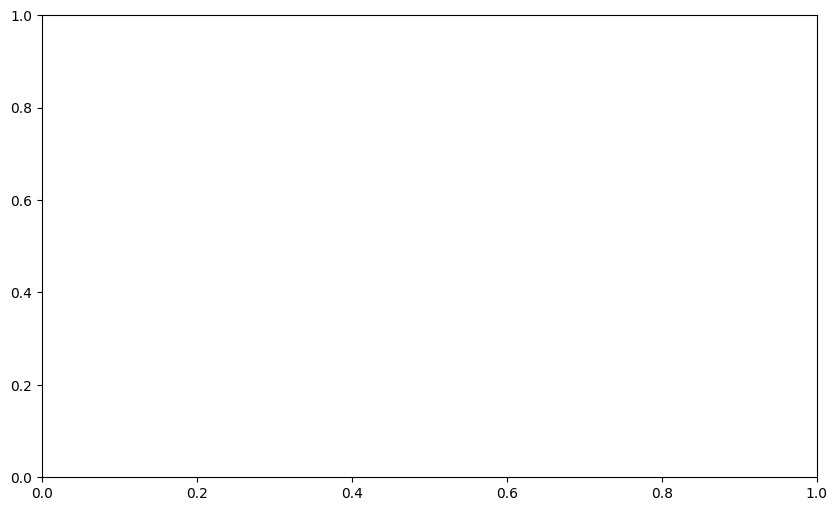

In [61]:
EnsembleVisualization(pred_files, climatology_file, climatology_std, gt_file, "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240822_003448_every_fine_15/inference_plots/").create_all_plots("tp")

In [3]:
import xarray as xr
import numpy as np

def transform_data(da):
    mask = ~np.isnan(da).any(dim=['latitude', 'longitude'])
    
    def get_valid_times(sample_mask):
        return np.where(sample_mask)[0]
    
    valid_time_indices = xr.apply_ufunc(
        get_valid_times,
        mask,
        input_core_dims=[['time']],
        output_core_dims=[['valid_time']],
        vectorize=True
    )
    
    new_da = da.isel(time=valid_time_indices)
    return new_da

In [4]:
pred_ds = [transform_data(xr.open_dataset(f)['tp']) for f in pred_files]
climatology_ds = transform_data(xr.open_dataset(climatology_file)['tp'])
gt_ds = transform_data(xr.open_dataset(gt_file)['tp'])


In [5]:
gt_ds.values.flatten().min()


0.31521916

In [6]:
def plot_time_series_spread(pred_ensemble, climatology_ds, gt_ds, climatolgy_std, lat_idx=0, lon_idx=0):
    gt_values  = gt_ds.isel(latitude=lat_idx, longitude=lon_idx).values.flatten()
    climatology_values = climatology_ds.isel(latitude=lat_idx, longitude=lon_idx).values.flatten()
    pred_values =[ds.isel(latitude=lat_idx, longitude=lon_idx).values.flatten() for ds in pred_ensemble]
    

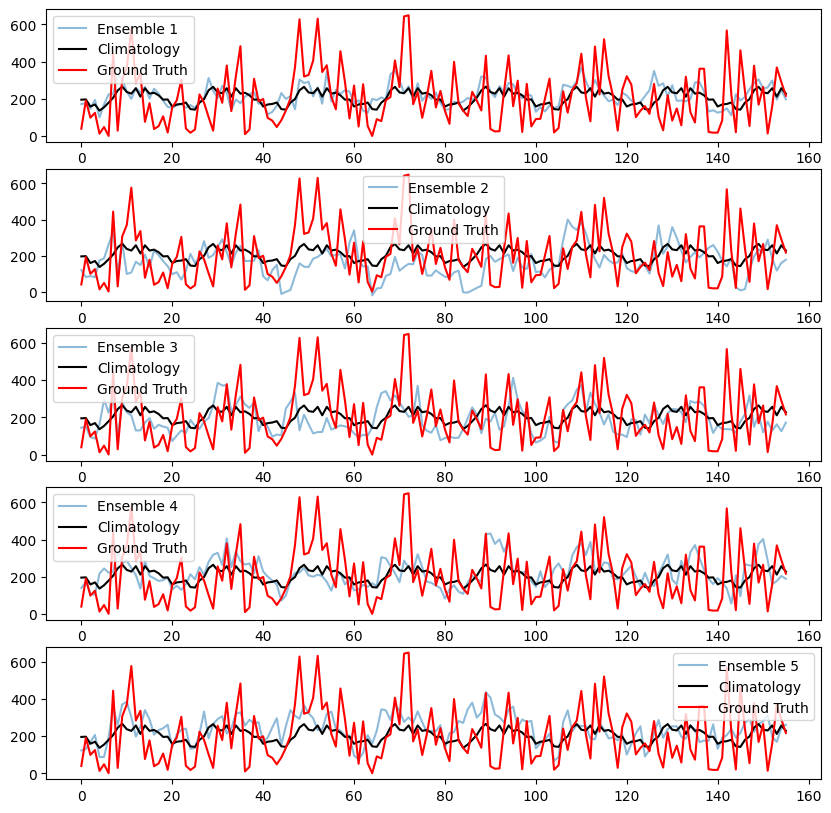

In [7]:
# Select a specific grid cell (adjust these indices as needed)
lat_idx, lon_idx = 0,4
# Extract data for the selected grid cell
gt_values = gt_ds.isel(latitude=lat_idx, longitude=lon_idx).values.flatten()

climatology_values = climatology_ds.isel(latitude=lat_idx, longitude=lon_idx).values.flatten()
ensemble_values = [ds.isel(latitude=lat_idx, longitude=lon_idx).values.flatten() for ds in pred_ds]

# do a bar plot for every ensemble on different figures
fig, axs = plt.subplots(len(ensemble_values), 1, figsize=(10, 10))
for i, ensemble in enumerate(ensemble_values):
    axs[i].plot(np.arange(ensemble.size), ensemble, alpha=0.5, label=f"Ensemble {i+1}")
    axs[i].plot(climatology_values, color='black', label='Climatology')
    axs[i].plot(gt_values, color='red', label='Ground Truth')
    axs[i].legend()



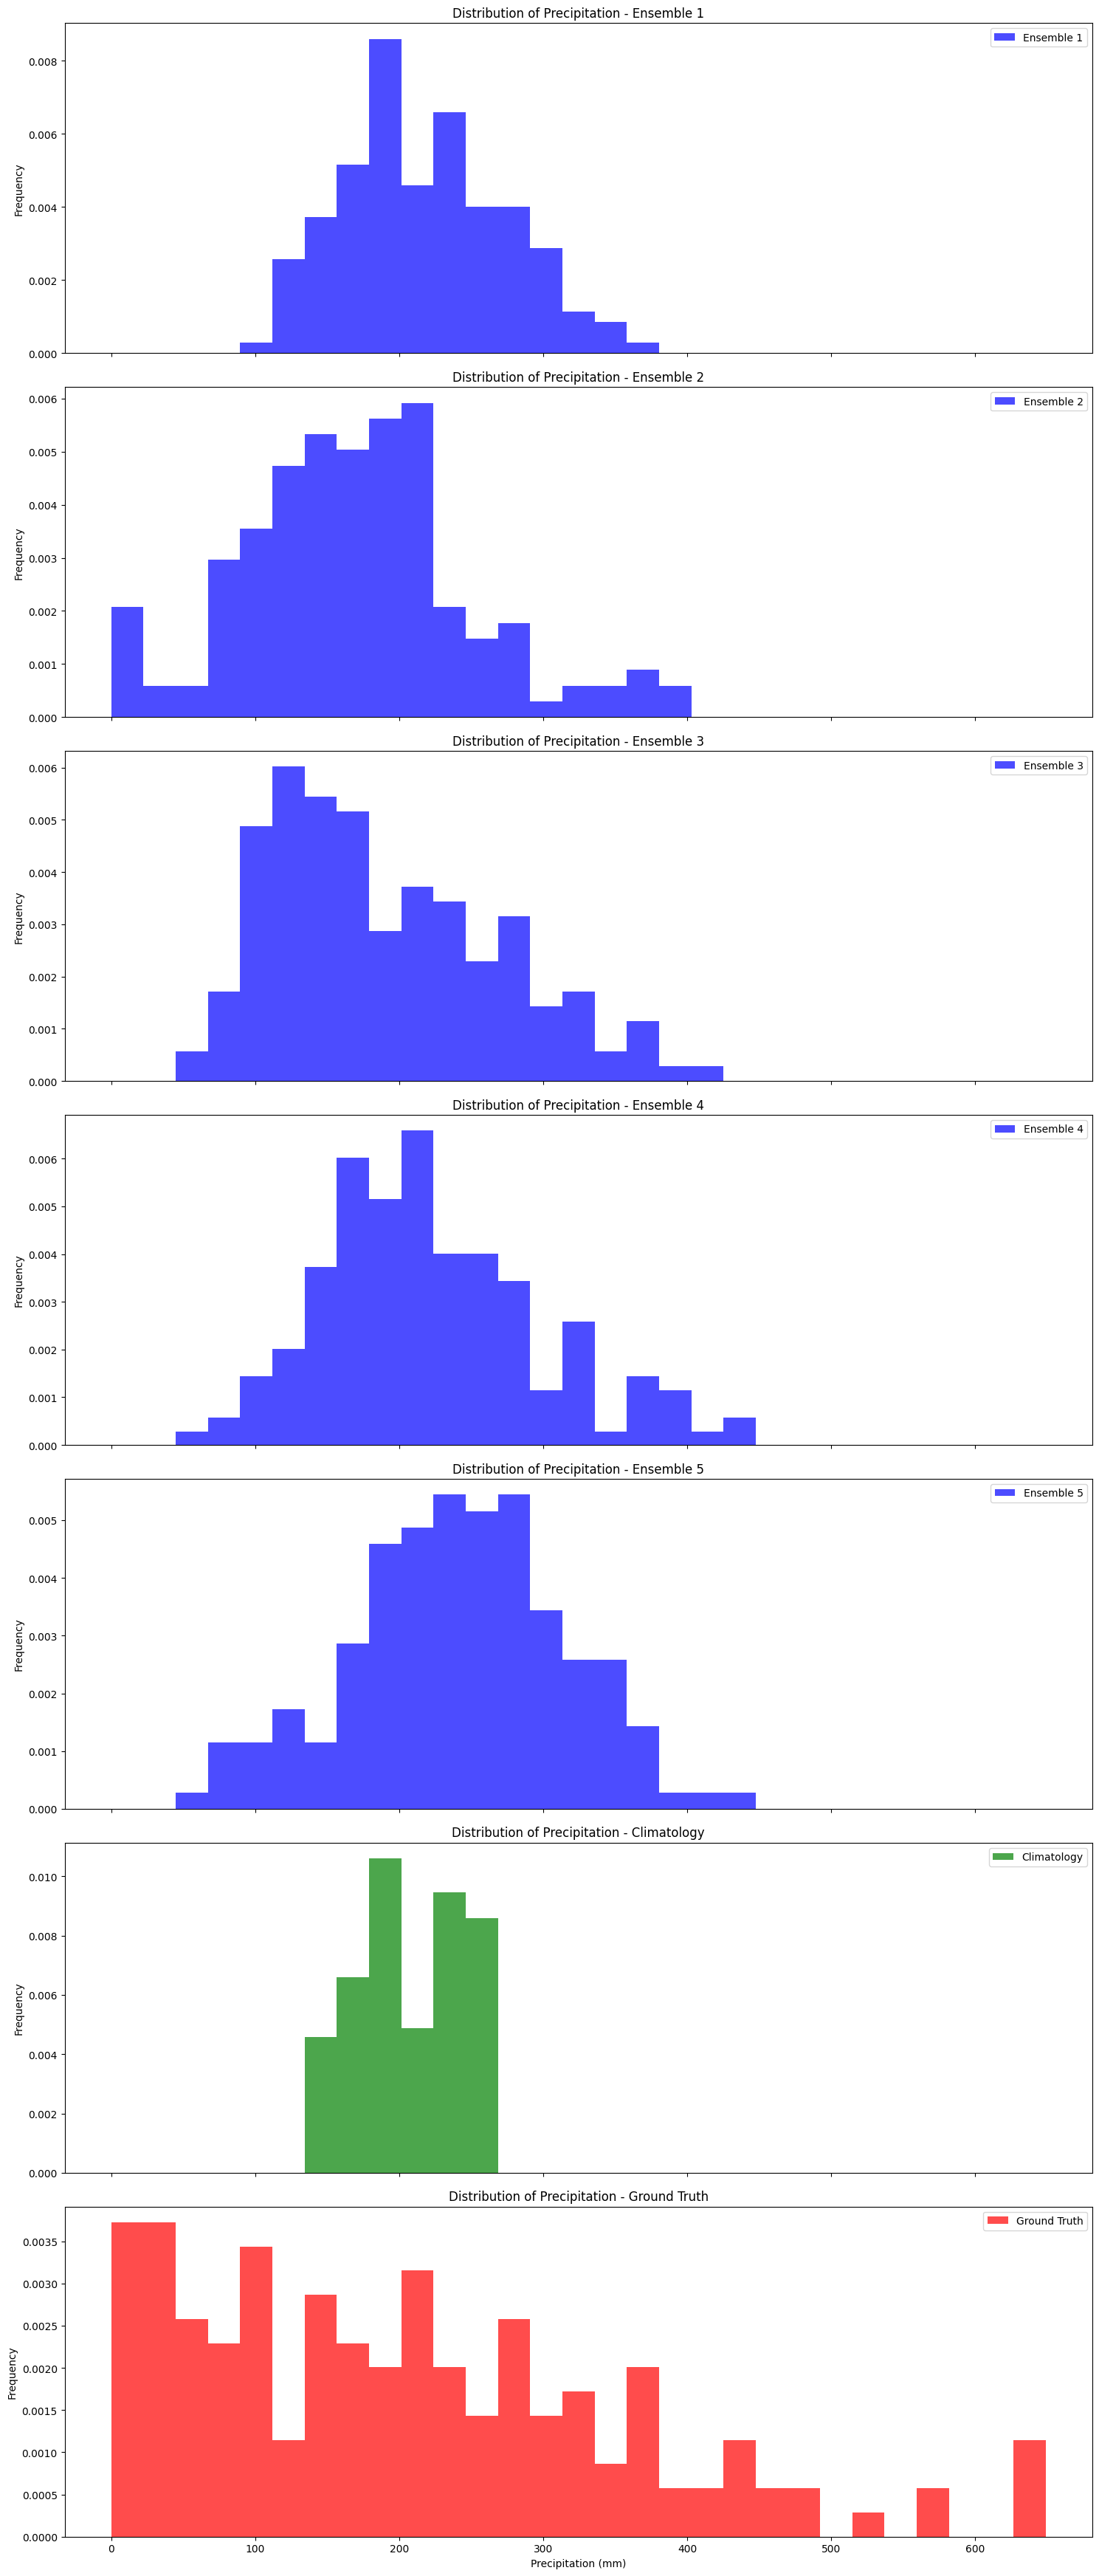

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Supposons que vous ayez déjà les données suivantes :
# gt_values, climatology_values, ensemble_values

# Nombre d'ensembles
n_ensembles = len(ensemble_values)

# Définir les paramètres de l'histogramme
bins = np.linspace(0, max(max(map(max, ensemble_values)), max(gt_values), max(climatology_values)), 30)

# Créer une figure pour chaque ensemble, plus deux figures supplémentaires
fig, axs = plt.subplots(n_ensembles + 2, 1, figsize=(15, 5*(n_ensembles + 2)), sharex=True)

for i, ensemble in enumerate(ensemble_values):
    # Tracer l'histogramme de l'ensemble
    axs[i].hist(ensemble, bins=bins, alpha=0.7, label=f"Ensemble {i+1}", color='blue', density=True)
    axs[i].set_title(f"Distribution of Precipitation - Ensemble {i+1}")
    axs[i].set_ylabel("Frequency")
    axs[i].legend()

# Tracer l'histogramme de la climatologie
axs[-2].hist(climatology_values, bins=bins, alpha=0.7, label='Climatology', color='green', density=True)
axs[-2].set_title("Distribution of Precipitation - Climatology")
axs[-2].set_ylabel("Frequency")
axs[-2].legend()

# Tracer l'histogramme de la vérité terrain
axs[-1].hist(gt_values, bins=bins, alpha=0.7, label='Ground Truth', color='red', density=True)
axs[-1].set_title("Distribution of Precipitation - Ground Truth")
axs[-1].set_ylabel("Frequency")
axs[-1].legend()

# Ajouter une étiquette d'axe x commune
plt.xlabel("Precipitation (mm)")

# Ajuster la mise en page
plt.tight_layout()

# Afficher le graphique
plt.show()


In [9]:


def compute_ensemble_metrics(pred_files, climatology_file, gt_file):
    # Load and transform data
    pred_ds = [transform_data(xr.open_dataset(f)['tp']) for f in pred_files]
    climatology_ds = transform_data(xr.open_dataset(climatology_file)['tp'])
    gt_ds = transform_data(xr.open_dataset(gt_file)['tp'])

    # Calculate ensemble mean
    pred_mean = sum(pred_ds) / len(pred_ds)

    # Calculate ensemble spread (standard deviation)
    pred_std = xr.concat(pred_ds, dim='ensemble').std(dim='ensemble')

    # Calculate errors
    ensemble_error = pred_mean - gt_ds
    climatology_error = climatology_ds - gt_ds

    # Calculate RMSEs
    ensemble_rmse = np.sqrt(((ensemble_error**2)))
    climatology_rmse = np.sqrt(((climatology_error**2)))

    # Calculate error variance
    error_variance = np.var(ensemble_error)

    # Calculate rank histogram
    ranks = sum([ds < gt_ds for ds in pred_ds])
    rank_hist, _ = np.histogram(ranks.values.flatten(), bins=len(pred_ds)+1, range=(-0.5, len(pred_ds)+0.5))

    return {
        'ensemble_mean': pred_mean,
        'ensemble_spread': pred_std,
        'ensemble_rmse': ensemble_rmse,
        'climatology_rmse': climatology_rmse,
        'error_variance': error_variance,
        'rank_histogram': rank_hist
    }

# Use the function
metrics = compute_ensemble_metrics(pred_files, climatology_file, gt_file)

# Print results
print("Ensemble RMSE:", metrics['ensemble_rmse'].values)
print("Climatology RMSE:", metrics['climatology_rmse'].values)
print("Error Variance:", metrics['error_variance'].values)
print("Rank Histogram:", metrics['rank_histogram'])

Ensemble RMSE: [[[[4.47217255e+01 1.10453186e+01 8.88687744e+01 1.78695923e+02
    1.00037453e+02]]

  [[1.28034515e+02 1.47807388e+02 1.78565308e+02 1.83401321e+02
    4.85129700e+01]]

  [[1.91136017e+01 1.33058624e+01 8.94876328e+01 9.39207382e+01
    2.21500854e+01]]

  [[4.18888168e+01 8.40081940e+01 4.83177795e+01 3.61614380e+01
    9.33677673e+00]]]


 [[[1.31445129e+02 8.44266815e+01 6.13816071e+01 2.22810822e+01
    1.35541718e+02]]

  [[2.79319702e+02 1.08902740e+02 7.58171387e+01 2.27069427e+02
    1.48173935e+02]]

  [[4.70977203e+02 1.08198158e+02 1.09986145e+02 2.03384552e+02
    2.24196533e+02]]

  [[1.27364426e+02 9.45006866e+01 1.90809250e+02 2.48020630e+01
    1.50650696e+02]]]


 [[[2.35012054e+01 1.65212860e+01 3.26393127e+01 2.40622955e+02
    1.92721970e+02]]

  [[1.04468689e+02 1.74646301e+01 3.08223419e+01 1.80977722e+02
    5.15347290e+00]]

  [[1.25652908e+02 1.08778641e+02 7.58805237e+01 2.37863190e+02
    1.22490936e+02]]

  [[2.47251495e+02 3.12591949e+02 3

In [23]:
metrics["ensemble_rmse"].isel(sample=0)
metrics["climatology_rmse"].isel(sample=0)
# faire la différence des deux
# faire la moyenne des différences



<xarray.DataArray 'tp' (valid_time: 4, latitude: 1, longitude: 5)>
array([[[ 88.07854 ,  69.59827 ,  23.947586, 141.11697 , 155.6933  ]],

       [[109.18607 ,  81.79233 , 111.756996, 130.2112  ,   5.959732]],

       [[ 26.365738,  49.869812,  17.896645,  52.13262 ,  59.97712 ]],

       [[ 62.64451 , 130.51111 ,  15.116539,  15.015411,  44.92131 ]]],
      dtype=float32)
Coordinates:
    time       (valid_time) datetime64[ns] 2016-02-18 2016-02-25 ... 2016-03-10
  * latitude   (latitude) float32 35.5
  * longitude  (longitude) float32 -5.5 4.5 14.5 24.5 34.5
    sample     int64 0
    dayofyear  (valid_time) int64 ...
Dimensions without coordinates: valid_time

In [10]:
gt.

SyntaxError: invalid syntax (2400726404.py, line 1)

In [ ]:
metrics["climatology_rmse"].mean().values
metrics["ensemble_rmse"].mean().values


array(114.62266854)

In [ ]:
gt["tp"].values

array([[[[276.53577924, 201.08097792, 147.54529297,  87.60162443,
           39.95676339]],

        [[ 73.04877788,  20.68117261,  12.52788305,  62.38292158,
          191.01083279]],

        [[208.40804279, 158.83278847, 123.40229005, 112.48682439,
           99.00663048]],

        ...,

        [[         nan,          nan,          nan,          nan,
                   nan]],

        [[         nan,          nan,          nan,          nan,
                   nan]],

        [[         nan,          nan,          nan,          nan,
                   nan]]],


       [[[         nan,          nan,          nan,          nan,
                   nan]],

        [[         nan,          nan,          nan,          nan,
                   nan]],

        [[         nan,          nan,          nan,          nan,
                   nan]],

        ...,

        [[         nan,          nan,          nan,          nan,
                   nan]],

        [[         nan,          nan,   

In [ ]:
gt_ds = xr.open_dataset(gt_file)

ValueError: 'x' is not 1-dimensional

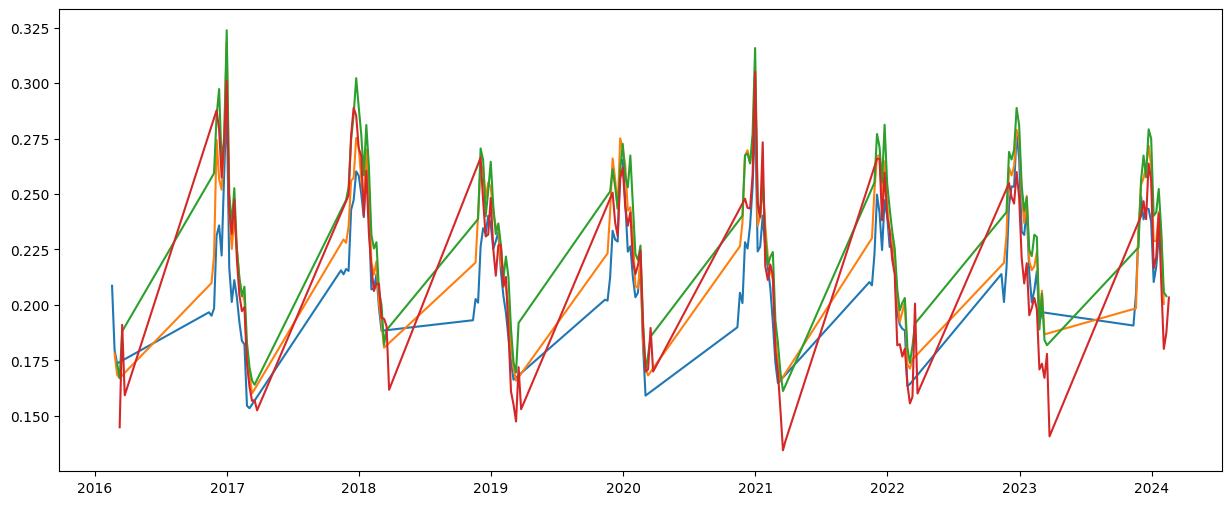

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

def create_plots(metrics, gt_ds):
    # 1. Ensemble Mean Error vs Climatology Error
    plt.figure(figsize=(10, 10))
    plt.scatter(metrics['ensemble_rmse'], metrics['climatology_rmse'])
    plt.plot([0, max(metrics['ensemble_rmse'].max(), metrics['climatology_rmse'].max())],
             [0, max(metrics['ensemble_rmse'].max(), metrics['climatology_rmse'].max())], 'r--')
    plt.xlabel('Ensemble RMSE')
    plt.ylabel('Climatology RMSE')
    plt.title('Ensemble vs Climatology RMSE')
    plt.savefig('ensemble_vs_climatology_rmse.png')
    plt.close()

    # 2. Ensemble Spread vs Error
    plt.figure(figsize=(10, 10))
    plt.scatter(metrics['ensemble_spread'].mean(['latitude', 'longitude']), 
                metrics['ensemble_rmse'].mean(['latitude', 'longitude']))
    plt.xlabel('Ensemble Spread')
    plt.ylabel('Ensemble RMSE')
    plt.title('Ensemble Spread vs RMSE')
    plt.savefig('ensemble_spread_vs_rmse.png')
    plt.close()

    # 3. Rank Histogram
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(metrics['rank_histogram'])), metrics['rank_histogram'])
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.title('Rank Histogram')
    plt.savefig('rank_histogram.png')
    plt.close()

    # 4. Time Series of Ensemble Mean, Spread, and Ground Truth
    plt.figure(figsize=(15, 6))
    mean = metrics['ensemble_mean'].mean(['latitude', 'longitude'])
    spread = metrics['ensemble_spread'].mean(['latitude', 'longitude'])
    truth = gt_ds.mean(['latitude', 'longitude'])
    plt.plot(mean.time, mean, label='Ensemble Mean')
    plt.fill_between(mean.time, mean - spread, mean + spread, alpha=0.3, label='Ensemble Spread')
    plt.plot(truth.time, truth, 'r.', label='Ground Truth')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Time Series of Ensemble Mean, Spread, and Ground Truth')
    plt.legend()
    plt.savefig('time_series.png')
    plt.close()

    # 5. Spatial Maps
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    metrics['ensemble_rmse'].plot(ax=ax1, transform=ccrs.PlateCarree())
    ax1.set_title('Ensemble RMSE')
    ax1.coastlines()
    
    metrics['climatology_rmse'].plot(ax=ax2, transform=ccrs.PlateCarree())
    ax2.set_title('Climatology RMSE')
    ax2.coastlines()
    
    metrics['ensemble_spread'].mean('time').plot(ax=ax3, transform=ccrs.PlateCarree())
    ax3.set_title('Ensemble Spread')
    ax3.coastlines()
    
    plt.tight_layout()
    plt.savefig('spatial_maps.png')
    plt.close()

# Use the function
create_plots(metrics, gt_ds)

In [ ]:
def compute_ensemble_stats(pred_files, variable='tp'):
    # Ouvrir tous les fichiers de prédiction
    pred_ds = [xr.open_dataset(f) for f in pred_files]
    
    # Extraire la variable spécifiée de chaque dataset
    pred_var = [ds[variable] for ds in pred_ds]
    
    # Calculer la moyenne de l'ensemble
    ensemble_mean = sum(pred_var) / len(pred_var)
    
    # Calculer l'écart-type de l'ensemble
    ensemble_std = xr.concat(pred_var, dim='ensemble').std(dim='ensemble')
    
    return ensemble_mean, ensemble_std

mean_tp, std_tp = compute_ensemble_stats(pred_files, variable='tp')

print("Moyenne de l'ensemble pour 'tp':", mean_tp)
print("Écart-type de l'ensemble pour 'tp':", std_tp)

KeyboardInterrupt: 

In [ ]:
def transform_data(da):
    # Create a mask for non-NaN values
    mask = ~np.isnan(da).any(dim=['latitude', 'longitude'])

    # Function to get valid time indices for each sample
    def get_valid_times(sample_mask):
        return np.where(sample_mask)[0]

    # Apply this function to each sample
    valid_time_indices = xr.apply_ufunc(
        get_valid_times,
        mask,
        input_core_dims=[['time']],
        output_core_dims=[['valid_time']],
        vectorize=True
    )

    # Create a new DataArray with only valid times for each sample
    new_da = da.isel(time=valid_time_indices)
    return new_da




In [ ]:
prediction_files = ["/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240813_172430_2005_coarse_t_fine_s/inference_plots/all_predictions.nc",
                    ]

climatology_file = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240815_123711_coarse_input_fine_target_10/inference_plots/all_climatology.nc"
ground_truth_file = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240815_123711_coarse_input_fine_target_10/inference_plots/all_ground_truths.nc"
entire_era_file = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20240815_123711_coarse_input_fine_target_10/1940_2024_target.nc"

In [ ]:
clim = xr.open_dataset(climatology_file)["tp"]
mean = clim.mean(dim=["time","longitude","latitude"]).mean()*1000
mean

<xarray.DataArray 'tp' ()>
array(192.29488075)

In [ ]:
ground_truth = xr.open_dataset(ground_truth_file)["tp"]
mean_gt = ground_truth.mean(dim=["time","longitude","latitude"]).mean()*1000


In [ ]:
pred_0 = xr.open_dataset(prediction_files[0])
pred_0

<xarray.Dataset>
Dimensions:    (time: 161, latitude: 1, longitude: 5, sample: 134)
Coordinates:
  * time       (time) datetime64[ns] 2016-02-18 2016-02-25 ... 2024-02-18
  * latitude   (latitude) float32 35.5
  * longitude  (longitude) float32 -5.5 4.5 14.5 24.5 34.5
  * sample     (sample) int64 0 1 2 3 4 5 6 7 ... 127 128 129 130 131 132 133
Data variables:
    tp         (sample, time, latitude, longitude) float32 ...

In [ ]:
mean = pred_0["tp"].mean(dim=["time","longitude","latitude"]).mean()*1000

#calculer le rmse entre pred_0 et ground_truth

rmse = np.sqrt(np.mean((pred_0 - ground_truth)**2))

# cacluler la std du rmse 
std_rmse = np.std((pred_0 - ground_truth)**2)

print( "rmse model ", rmse*1000)
print( "std_rmse model", std_rmse*1000)
std_rmse

rmse model  <xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 141.6
std_rmse model <xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 32.21


<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.03221

In [ ]:
# rmse clim 
rmse_clim = np.sqrt(np.mean((clim - ground_truth)**2))

std_clim = np.std((clim - ground_truth)**2)

print( "rmse_clim", rmse_clim*1000)
print( "std_clim", std_clim*1000)
print( "mean gt", mean_gt)

rmse_clim <xarray.DataArray 'tp' ()>
array(136.98768616)
std_clim <xarray.DataArray 'tp' ()>
array(31.66821972)
mean gt <xarray.DataArray 'tp' ()>
array(171.94955051)


In [ ]:
ground_truth = xr.open_dataset(ground_truth_file)
ground_truth["tp"].values


array([[[[0.27653578, 0.20108098, 0.1475453 , 0.08760163, 0.03995675]],

        [[0.07304878, 0.02068117, 0.01252789, 0.06238294, 0.19101083]],

        [[0.20840804, 0.15883279, 0.12340229, 0.11248682, 0.09900663]],

        ...,

        [[       nan,        nan,        nan,        nan,        nan]],

        [[       nan,        nan,        nan,        nan,        nan]],

        [[       nan,        nan,        nan,        nan,        nan]]],


       [[[       nan,        nan,        nan,        nan,        nan]],

        [[0.07304878, 0.02068117, 0.01252789, 0.06238294, 0.19101083]],

        [[0.20840804, 0.15883279, 0.12340229, 0.11248682, 0.09900663]],

        ...,

        [[       nan,        nan,        nan,        nan,        nan]],

        [[       nan,        nan,        nan,        nan,        nan]],

        [[       nan,        nan,        nan,        nan,        nan]]],


       [[[       nan,        nan,        nan,        nan,        nan]],

        [[       na

In [ ]:
pred_0["tp"].values

array([[[[0.22127624, 0.14489308, 0.18876237, 0.21295698, 0.17982751]],

        [[0.2287085 , 0.14557934, 0.18625692, 0.20866428, 0.17509463]],

        [[0.22113341, 0.14225289, 0.18116501, 0.20927909, 0.17385243]],

        ...,

        [[       nan,        nan,        nan,        nan,        nan]],

        [[       nan,        nan,        nan,        nan,        nan]],

        [[       nan,        nan,        nan,        nan,        nan]]],


       [[[       nan,        nan,        nan,        nan,        nan]],

        [[0.2011699 , 0.14268635, 0.18592696, 0.21049878, 0.17880899]],

        [[0.20070666, 0.14058939, 0.18286633, 0.21068497, 0.1754359 ]],

        ...,

        [[       nan,        nan,        nan,        nan,        nan]],

        [[       nan,        nan,        nan,        nan,        nan]],

        [[       nan,        nan,        nan,        nan,        nan]]],


       [[[       nan,        nan,        nan,        nan,        nan]],

        [[       na

In [ ]:
clim = xr.open_dataset(climatology_file)["tp"]

clim.values

array([[[[0.18845724, 0.1314827 , 0.17149287, 0.22871861, 0.19565004]],

        [[0.18223485, 0.1024735 , 0.12428489, 0.19259413, 0.19697057]],

        [[0.1820423 , 0.10896298, 0.14129893, 0.16461945, 0.15898375]],

        ...,

        [[       nan,        nan,        nan,        nan,        nan]],

        [[       nan,        nan,        nan,        nan,        nan]],

        [[       nan,        nan,        nan,        nan,        nan]]],


       [[[       nan,        nan,        nan,        nan,        nan]],

        [[0.18223485, 0.1024735 , 0.12428489, 0.19259413, 0.19697057]],

        [[0.1820423 , 0.10896298, 0.14129893, 0.16461945, 0.15898375]],

        ...,

        [[       nan,        nan,        nan,        nan,        nan]],

        [[       nan,        nan,        nan,        nan,        nan]],

        [[       nan,        nan,        nan,        nan,        nan]]],


       [[[       nan,        nan,        nan,        nan,        nan]],

        [[       na

## Evaluation

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import os

class ModelEvaluation:
    def __init__(self, prediction_files, ground_truth_file, climatology_file, save_dir, entire_era_file):
        
        self.prediction_datasets = [xr.open_dataset(file) for file in prediction_files]
        self.ground_truth_dataset = xr.open_dataset(ground_truth_file)
        self.climatology_dataset = xr.open_dataset(climatology_file)
        self.era_entire_dataset = xr.open_dataset(entire_era_file)
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        self.save_folder = os.path.join(self.save_dir, prediction_files[0].split('/')[-3])
        os.makedirs(self.save_folder, exist_ok=True)
        
        self.target_variables = list(self.ground_truth_dataset.data_vars)
        self.extreme_thresholds = self._calculate_extreme_thresholds()
        self.nb_ensemble = len(self.prediction_datasets)

    def _calculate_extreme_thresholds(self):
        thresholds = {}
        for var in self.target_variables:
            threshold = self.era_entire_dataset[var].quantile(0.66, dim='time')
            thresholds[var] = threshold
        return thresholds
    
    def _replace_time_lt(self, da):
        lead_time = np.arange(1, len(da.time) + 1)

        # Remplacer la coordonnée time par lead_time
        da_new = da.assign_coords(lead_time=('time', lead_time)).swap_dims({'time': 'lead_time'})
        da_new = da_new.drop_vars('time')
        return da_new
    
    def calculate_skill_scores(self,ensemble_score, climatology_score, valid_samples):
        """
        Calcule le Skill Score (RPSS ou BSS) à partir des scores de l'ensemble et de la climatologie.
        
        :param ensemble_score: Score de l'ensemble (RPS ou BS)
        :param climatology_score: Score de la climatologie (RPS ou BS)
        :param valid_samples: Masque des échantillons valides
        :return: Skill Score (RPSS ou BSS)
        """
        # Ajouter une petite valeur à climatology_score pour éviter la division par zéro
        epsilon = 1e-10
        climatology_score_safe = climatology_score + epsilon
        
        # Calculer le Skill Score
        skill_score = 1 - (ensemble_score / climatology_score_safe)
        
        # Gérer les cas spéciaux
        skill_score = xr.where(skill_score < -1, -1, skill_score)  # Limiter le score minimum à -1
        skill_score = xr.where((ensemble_score == 0) & (climatology_score == 0), 0, skill_score)  # Score de 0 si les deux sont zéro
        
        # Appliquer le masque des échantillons valides
        skill_score = skill_score.where(valid_samples > 0)
        
        return skill_score
    
    def safe_divide(self,a, b):
        """
        Effectue une division sûre, en convertissant le résultat en float64.
        """
        return (a.astype('float64') / b).astype('float64')
    
    def calculate_scores(self):
        self.rpss = {var: [] for var in self.target_variables}
        self.brier_scores_ensemble = {var: [] for var in self.target_variables}
        self.brier_scores_climatology = {var: [] for var in self.target_variables}
        
        for var in self.target_variables:
            rps_ensemble = 0
            rps_climatology = 0
            valid_samples = 0
            bs_ensemble = 0
            bs_climatology = 0
                
            for sample in range(len(self.ground_truth_dataset.sample)):
                truth = self.ground_truth_dataset[var].isel(sample=sample)
                clim = self.climatology_dataset[var].isel(sample=sample)
                
                preds = [pred_dataset[var].isel(sample=sample) for pred_dataset in self.prediction_datasets]
                
                truth_valid = truth.dropna(dim='time', how='all')
                clim_valid = clim.dropna(dim='time', how='all')
                preds_valid = [pred.dropna(dim='time', how='all') for pred in preds]
                
                if len(truth_valid) == 0:
                    continue

                sample_dates = truth_valid.time.values
                # remplacer time par lead time :

                truth_valid = self._replace_time_lt(truth_valid)
                clim_valid = self._replace_time_lt(clim_valid)
                preds_valid = [self._replace_time_lt(pred) for pred in preds_valid]
                
                categories = self._calculate_historical_categories(var, sample_dates)
                
                prob_ensemble = self._calculate_ensemble_probabilities(preds_valid, categories)
                prob_climatology = self._calculate_probabilities(clim_valid, categories)
                obs_categorical = self._categorize_observations(truth_valid, categories)

                threshold = self.extreme_thresholds[var]
                # Calcul des probabilités d'événements extrêmes pour l'ensemble
                prob_extreme_ensemble = (xr.concat(preds_valid, dim='ensemble') > threshold).mean(dim=['ensemble'])
                
                # Calcul des probabilités d'événements extrêmes pour la climatologie
                prob_extreme_climatology = (clim_valid > threshold).astype(int)
                
                # Observations des événements extrêmes
                obs_extreme = (truth_valid > threshold).astype(int)
                
                bs_ensemble += self._calculate_brier_score(prob_extreme_ensemble, obs_extreme)
                bs_climatology += self._calculate_brier_score(prob_extreme_climatology, obs_extreme)
                
                rps_ensemble += self._calculate_rps(prob_ensemble, obs_categorical)
                rps_climatology += self._calculate_rps(prob_climatology, obs_categorical)
                valid_samples += 1
            
            rpss = self.calculate_skill_scores(rps_ensemble, rps_climatology, valid_samples)
            bss = self.calculate_skill_scores(bs_ensemble, bs_climatology, valid_samples)
            rps_ensemble = self.safe_divide(rps_ensemble, valid_samples)
            rps_climatology = self.safe_divide(rps_climatology, valid_samples)
            bs_ensemble = self.safe_divide(bs_ensemble, valid_samples)
            bs_climatology = self.safe_divide(bs_climatology, valid_samples)

            self.save_scores(var, rpss, bss, rps_ensemble, rps_climatology, bs_ensemble, bs_climatology)
            self.plot_rpss_maps(var,rpss,bss)

    def _calculate_ensemble_probabilities(self, preds, categories):
        probs = [self._calculate_probabilities(pred, categories) for pred in preds]
        return sum(probs) / len(probs)

    def _calculate_brier_score(self, forecast_probabilities, observations):
        return ((forecast_probabilities - observations) ** 2)
    
    def _calculate_probabilities(self, data, categories):
        quantile_0 = categories.isel(quantile=0)
        quantile_1 = categories.isel(quantile=1)
        
        below = (data <= quantile_0)
        middle = (data > quantile_0) & (data <= quantile_1)
        above = (data > quantile_1)
        middle = middle.assign_coords(quantile= 0.5)
        
        probs = xr.concat([below, middle, above], dim=pd.Index(['below', 'middle', 'above'], name='category'))
        return probs

    def _categorize_observations(self, observations, categories):
        below = (observations <= categories.isel(quantile=0)).astype(int)
        middle = ((observations > categories.isel(quantile=0)) & (observations <= categories.isel(quantile=1))).astype(int)
        above = (observations > categories.isel(quantile=1)).astype(int)
        middle = middle.assign_coords(quantile= 0.5)
        
        probs = xr.concat([below, middle, above], dim=pd.Index(['below', 'middle', 'above'], name='category'))
        return probs

    def _calculate_rps(self, forecast_probabilities, obs_probabilities):
        cumulative_forecast = forecast_probabilities.cumsum(dim='category')
        cumulative_obs = obs_probabilities.cumsum(dim='category')
        return ((cumulative_forecast - cumulative_obs) ** 2).mean(dim='category')
    
    def _calculate_historical_categories(self, var, sample_dates):
        historical_data = []
        seen_times = set()

        for date in sample_dates:
            pd_date = pd.Timestamp(date)
            same_day_month_samples = self.ground_truth_dataset[var].sel(
                time=self.ground_truth_dataset.time.dt.dayofyear == pd_date.dayofyear
            )
            for sample_idx in range(len(same_day_month_samples.sample)):
                sample_data = same_day_month_samples.isel(sample=sample_idx)
                sample_data_non_nan = sample_data.dropna(dim='time', how='all')
                sample_times = set(sample_data_non_nan.time.values)

                new_times = sample_times - seen_times
                if new_times:
                    seen_times.update(new_times)  # Mettre à jour les dates vues
                    historical_data.append(sample_data_non_nan.sel(time=list(new_times)))

        if historical_data:
            historical_data = xr.concat(historical_data, dim='time')
            terciles = historical_data.quantile([0.3333, 0.6667], dim='time')

            return terciles
        else:
            return xr.DataArray(np.nan, dims=['quantile', 'lat', 'lon'], coords={'quantile': [0.3333, 0.6667]})
        
    def plot_rpss_maps(self, var , rpss, bss):
        # plot rpss 
        rpss_mean = rpss.mean(dim='lead_time')
        
        lats = [30] + list(rpss_mean.latitude.values) + [45]
        lons = [-10] + list(rpss_mean.longitude.values) + [40]

        # Créer la carte
        fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Utiliser pcolormesh au lieu de imshow pour une meilleure représentation des données discrètes
        vmin = min(rpss_mean.min().values, -0.2)
        vmax = max(rpss_mean.max().values, 0.2)
        im = ax.imshow(rpss_mean, cmap="RdYlBu", transform=ccrs.PlateCarree(),
                           extent=[lons[0], lons[-1], lats[0], lats[-1]], vmin=vmin, vmax=vmax)
        
        # Ajouter les caractéristiques de la carte
        ax.coastlines(resolution='50m', color='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linestyle=':', color='black', linewidth=0.5)
        ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey', alpha=0.3)
        ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='lightblue', alpha=0.3)
        
        # Configurer la grille
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        lat_margin = 0.5  # ajustez selon vos besoins
        ax.set_extent([rpss_mean.longitude.min(), rpss_mean.longitude.max(),
                    rpss_mean.latitude.min() - lat_margin, rpss_mean.latitude.max() + lat_margin], 
                    crs=ccrs.PlateCarree())
        gl.xlocator = mticker.FixedLocator(np.arange(lons[0], lons[-1], 10))
        gl.ylocator = mticker.FixedLocator(np.arange(lats[0], lats[-1], 5))
        gl.top_labels = False
        gl.right_labels = False
        
        # Ajouter la barre de couleur
        cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.08)
        cbar.set_label(f'RPSS - {var}', fontsize=12)
        
        # Configurer le titre et les limites de la carte
        plt.title(f'Mean RPSS - {var} - {self.nb_ensemble} ensemble ', fontsize=16)
        ax.set_extent([lons[0], lons[-1], lats[0], lats[-1]], crs=ccrs.PlateCarree())
        
        # Sauvegarder la figure
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_folder, f'{var}_rpss_map.png'), 
                    bbox_inches='tight', dpi=300)
        plt.close()

        bss_mean = bss.mean(dim='lead_time')
        lats = [30] + list(bss_mean.latitude.values) + [45]
        lons = [-10] + list(bss_mean.longitude.values) + [40]

        # Créer la carte
        fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Utiliser pcolormesh au lieu de imshow pour une meilleure représentation des données discrètes
        vmin = min(bss_mean.min().values, -0.15)
        vmax = max(bss_mean.max().values, 0.15)
        im = ax.imshow(bss_mean, cmap='RdYlBu', transform=ccrs.PlateCarree(),
                           extent=[lons[0], lons[-1], lats[0], lats[-1]], vmin=vmin, vmax=vmax)
        
        # Ajouter les caractéristiques de la carte
        ax.coastlines(resolution='50m', color='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linestyle=':', color='black', linewidth=0.5)
        ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey', alpha=0.3)
        ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='lightblue', alpha=0.3)
        
        # Configurer la grille
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = mticker.FixedLocator(np.arange(lons[0], lons[-1], 10))
        gl.ylocator = mticker.FixedLocator(np.arange(lats[0], lats[-1], 5))
        gl.top_labels = False
        gl.right_labels = False
        
        # Ajouter la barre de couleur
        cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.08)
        cbar.set_label(f'bss - {var}', fontsize=12)
        
        # Configurer le titre et les limites de la carte
        plt.title(f'Mean BSS (upper tercile) - {var}- {self.nb_ensemble} ensemble', fontsize=16)
        ax.set_extent([lons[0], lons[-1], lats[0], lats[-1]], crs=ccrs.PlateCarree())
        
        # Sauvegarder la figure
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_folder, f'{var}_bss_map.png'), 
                    bbox_inches='tight', dpi=300)
        plt.close()



    def save_scores(self, var, rpss, bss, rps_ensemble, rps_climatology, bs_ensemble, bs_climatology):
        rpss.name = f'{var}_rpss'
        bss.name = f'{var}_bss'
        
        # Sauvegarder les scores complets (avec toutes les dimensions)
        rpss.to_netcdf(os.path.join(self.save_folder, f'{var}_rpss.nc'))
        bss.to_netcdf(os.path.join(self.save_folder, f'{var}_bss.nc'))
        
        # Calculer et sauvegarder les moyennes spatiales
        rpss_mean = rpss.mean(dim=['latitude', 'longitude'])
        bss_mean = bss.mean(dim=['latitude', 'longitude'])
        
        df = pd.DataFrame({
            'lead_time': rpss.lead_time.values,
            f'{var}_rpss': rpss_mean.values,
            f'{var}_bss': bss_mean.values
        })

            # Calculer les moyennes pour rps et bs
        rps_ensemble_mean = rps_ensemble.mean(dim=['latitude', 'longitude'])
        rps_climatology_mean = rps_climatology.mean(dim=['latitude', 'longitude'])
        bs_ensemble_mean = bs_ensemble.mean(dim=['latitude', 'longitude'])
        bs_climatology_mean = bs_climatology.mean(dim=['latitude', 'longitude'])

        # Ajouter ces scores au DataFrame
        df[f'{var}_rps_ensemble'] = rps_ensemble_mean.values
        df[f'{var}_rps_climatology'] = rps_climatology_mean.values
        df[f'{var}_bs_ensemble'] = bs_ensemble_mean.values
        df[f'{var}_bs_climatology'] = bs_climatology_mean.values

        # Calculer la moyenne globale pour chaque score
        mean_row = pd.DataFrame({
            'lead_time': ['mean'],
            f'{var}_rpss': [rpss_mean.mean().values.item()],
            f'{var}_bss': [bss_mean.mean().values.item()],
            f'{var}_rps_ensemble': [rps_ensemble_mean.mean().values.item()],
            f'{var}_rps_climatology': [rps_climatology_mean.mean().values.item()],
            f'{var}_bs_ensemble': [bs_ensemble_mean.mean().values.item()],
            f'{var}_bs_climatology': [bs_climatology_mean.mean().values.item()]
        })

        # Concaténer la ligne de moyenne avec le DataFrame principal
        df = pd.concat([df, mean_row], ignore_index=True)
        
        # Sauvegarder le DataFrame dans un fichier CSV
        df.to_csv(os.path.join(self.save_folder, f'{var}_scores.csv'), index=False)

        
        print(f"Scores for {var} saved successfully.")

# Usage remains the same

save_folder = './evaluation_results'


evaluator = ModelEvaluation(prediction_files, ground_truth_file, climatology_file, save_folder, entire_era_file)
evaluator.calculate_scores()

Scores for tp saved successfully.


/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
